## confirm the profile convolution of clustering is not neccessary
We can skip this convolution to speed up MCMC

Text(0, 0.5, '$w(\\theta)/\\Sigma^c(\\theta)$')

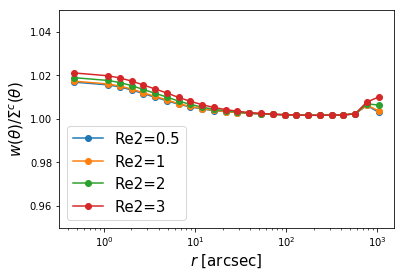

In [16]:
from run_fit import *
param_fit = fit_stacking_mcmc(1, 4, 0)
for Re2 in [0.5, 1, 2, 3]:
    _ = param_fit.get_profgal_model(Re2=Re2)
    profclus_arr = param_fit.get_profclus_model_exact()
    plt.semilogx(param_fit.rfull_arr, param_fit.w_arr/profclus_arr,'o-',label='Re2={}'.format(Re2))
plt.ylim([0.95,1.05])
plt.legend(fontsize=15)
plt.xlabel(r'$r$ [arcsec]',fontsize=15)
plt.ylabel(r'$w(\theta)/\Sigma^c(\theta)$',fontsize=15)

Text(0, 0.5, '$w(\\theta)/\\,(b_g(z)b_I(z)\\frac{dI}{dz})$')

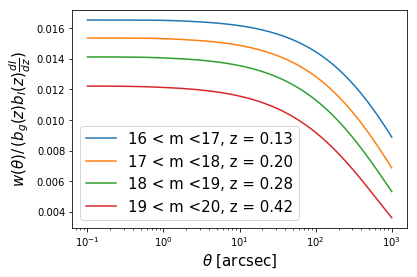

In [2]:
from clustering import *
from run_fit import *
param_fit = fit_stacking_mcmc(1, 4, 0)
theta_arr = np.logspace(-1,3,100)
for im,z in param_fit.zm_dict.items():
    w_arr = wgI_zm_approx(z, theta_arr)
    plt.semilogx(theta_arr, w_arr, label='%d < m <%d, z = %.2f'%(im+16, im+17, z))
plt.legend(fontsize=15)
plt.xlabel(r'$\theta$ [arcsec]', fontsize=15)
plt.ylabel(r'$w(\theta)/\,(b_g(z)b_I(z)\frac{dI}{dz})$', fontsize=15)

try convolution by integrate $r$ & $\theta$, but it's not really faster than fftconvolve

In [202]:
r_arr = param_fit.rfull_arr
psf_arr = param_fit.profpsf_arr
prof_arr = gal_profile_model().Wang19_profile(param_fit.rfull_arr, param_fit.im, Re2=2)['I_arr']

tcklogpsf = interpolate.splrep(np.log(r_arr),np.log(psf_arr), k=1)
tckloggal = interpolate.splrep(np.log(r_arr),np.log(prof_arr), k=1)

profgalconv_arr = np.zeros_like(galprof)
thint_arr = np.arange(0,2*np.pi,0.01)
rint_arr = np.arange(0.01,1200,0.1)
for ir,r in enumerate(r_arr):
    
    fint_arr = np.zeros_like(rint_arr)
    for ir1,r1 in enumerate(rint_arr):
        arg = np.sqrt((r+r1*np.cos(thint_arr))**2 + (r1*np.sin(thint_arr))**2)
        fint = np.exp(interpolate.splev(np.log(arg),tckloggal))
        fint_arr[ir1] = np.sum(fint) * (thint_arr[1] - thint_arr[0])
    
    gint_arr = np.exp(interpolate.splev(np.log(rint_arr),tcklogpsf))
    
    num = np.sum(fint_arr * gint_arr * rint_arr) * (rint_arr[1] - rint_arr[0])
    den = np.sum(gint_arr * rint_arr) * (rint_arr[1] - rint_arr[0]) * 2 * np.pi
    profgalconv_arr[ir] = num / den

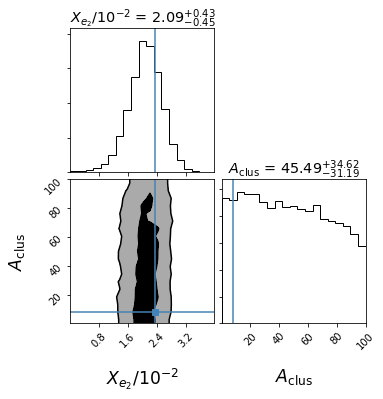

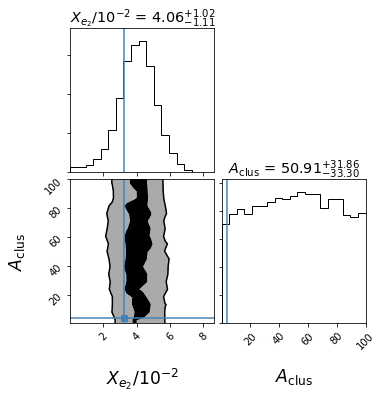

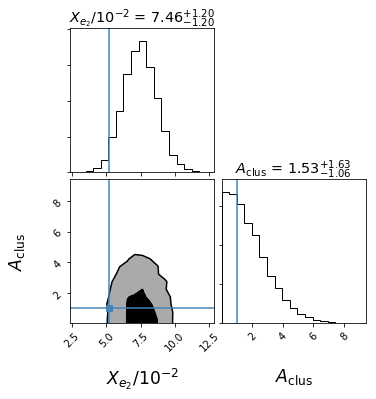

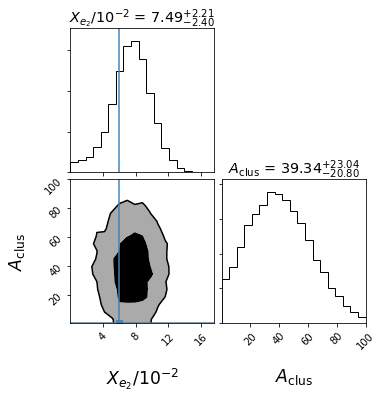

In [7]:
from run_fit import *
import corner

inst = 1

for ifield in [4]:
    if ifield==0:
        truths_arr = []
    for im in range(4):
        if ifield==0:
            param_fit = fit_stacking_mcmc(inst, 4, im)
            savedir = mypaths['alldat'] + 'TM' + str(param_fit.inst) + '/'
            savename = 'mcmc_2par_joint' + \
            '_m' + str(param_fit.m_min) + '_' + str(param_fit.m_max) + '.npy'
        else:
            param_fit = fit_stacking_mcmc(inst, ifield, im)
            savedir = mypaths['alldat'] + 'TM' + str(param_fit.inst) + '/'
            savename = 'mcmc_2par_' + param_fit.field + \
            '_m' + str(param_fit.m_min) + '_' + str(param_fit.m_max) + '.npy'

        samples = np.load(savedir + savename)
        steps, nwalkers, nparams = samples.shape

        flatsamps = samples.copy()
        flatsamps[:,:,0] = flatsamps[:,:,0] * 1e2
        flatsamps = flatsamps[100:,:,:].reshape((-1,2))

        bins0 = np.linspace(np.min(flatsamps[:,0]), np.max(flatsamps[:,0]), 20)
        bins1 = np.linspace(np.min(flatsamps[:,1]), np.max(flatsamps[:,1]), 20)
        
        if ifield==0:
            truths_arr.append(np.median(flatsamps, axis=0))

        levels= 1.0 - np.exp(-0.5 * np.arange(1, 2.1, 1) ** 2)
        figure = corner.corner(flatsamps, levels = levels,fill_contours=True,plot_datapoints=False,
                               bins=[bins0, bins1],label_kwargs={'fontsize':'xx-large'},
#                                range=[(0,12),(0,20)],
                               title_kwargs={'fontsize':'x-large'},
                               show_titles=True,labels=["$X_{e_2}/10^{-2}$", r"$A_{\rm clus}$"],
                               truths=truths_arr[im])